<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/Getting_started_TensorFlow2/Saving_loading_models/Saving_Loading_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install --no-cache-dir -qU pip wheel
pip install --no-cache-dir -qU numpy pandas matplotlib seaborn scikit-learn
pip install --no-cache-dir -qU tensorflow-gpu tensorflow_hub
pip check

In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.get_logger().setLevel('ERROR')

import tensorflow_hub as hub

# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='sigmoid', 
        input_shape=(10,)),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.SGD()
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'my_model', save_weights_only=True)
# checkpoint
# my_model.data-00000-of-00001
# my_model.index

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'keras_model.h5', save_weights_only=True)
# keras_model.h5

model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint])

model.load_weights('my_model')
model.load_weights('keras_model.h5')

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='sigmoid', 
        input_shape=(10,)),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.SGD()
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=2)

model.fit(X_train, y_train, validation_split=0.2, 
    epochs=50, callbacks=[early_stopping])

model.save_weights('my_model')

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [3]:
# Import the CIFAR-10 dataset and rescale the pixel values
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

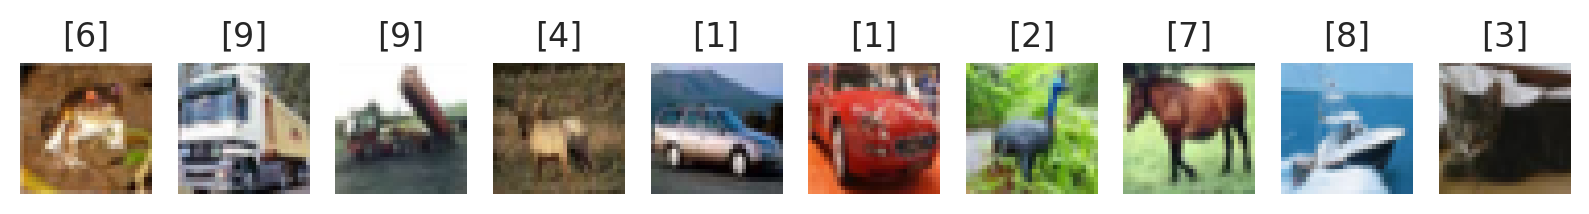

In [4]:
# Plot the first 10 CIFAR-10 images
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])
    ax[i].set_title(f"{y_train[i]}")
plt.show()

#### Introduce two useful functions

In [5]:
# Introduce function to test model accuracy
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(
        x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [6]:
# Introduce function that creates a new instance of a simple CNN
def get_new_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=16, input_shape=(32, 32, 3), 
            kernel_size=(3, 3), activation='relu', name='conv_1'),
        tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), 
            activation='relu', name='conv_2'),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(units=32, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return model

#### Create simple convolutional neural network classifier

In [8]:
# Create an instance of the model and show model summary
model = get_new_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 8)           0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                12576     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 14,514
Trainable params: 14,514
Non-trai

In [9]:
# Test accuracy of the untrained model, around 10% (random)
get_test_accuracy(model, x_test, y_test)

2022-11-03 15:18:56.340224: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


accuracy: 0.102


#### Train model with checkpoints

In [10]:
class PlotHistory():
    plt_nrows = 1
    plt_ncols = 2
    plt_figsize = (15, 5)
    
    def __init__(self, history, metrics=['loss']):
        super().__init__()
        self.history = history
        self.metrics = metrics
        
    @classmethod
    def _create_plot(cls):
        return plt.subplots(nrows=cls.plt_nrows,
            ncols=cls.plt_ncols, figsize=cls.plt_figsize)
    
    def plot(self):
        df_history = pd.DataFrame(self.history.history,
            index=self.history.epoch)
        fig, axes = self._create_plot()
        for ax, metric in zip(axes, self.metrics):
            sns.lineplot(ax=ax, data=df_history, 
                x=df_history.index+1, y=metric, label='train')
            try:
                sns.lineplot(ax=ax, data=df_history,
                    x=df_history.index+1, y=f'val_{metric}',
                    label='valid')
            except Exception:
                pass
            ax.legend(loc='best')
            ax.set_xlabel('epoch')
            ax.set_ylabel(f'{metric}')
            ax.set_title(f'{metric} vs. epoch')
        fig.tight_layout()
        plt.show()

In [11]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
    frequency='epoch', save_weights_only=True, verbose=2)


Epoch 1: saving model to model_checkpoints/checkpoint

Epoch 2: saving model to model_checkpoints/checkpoint

Epoch 3: saving model to model_checkpoints/checkpoint


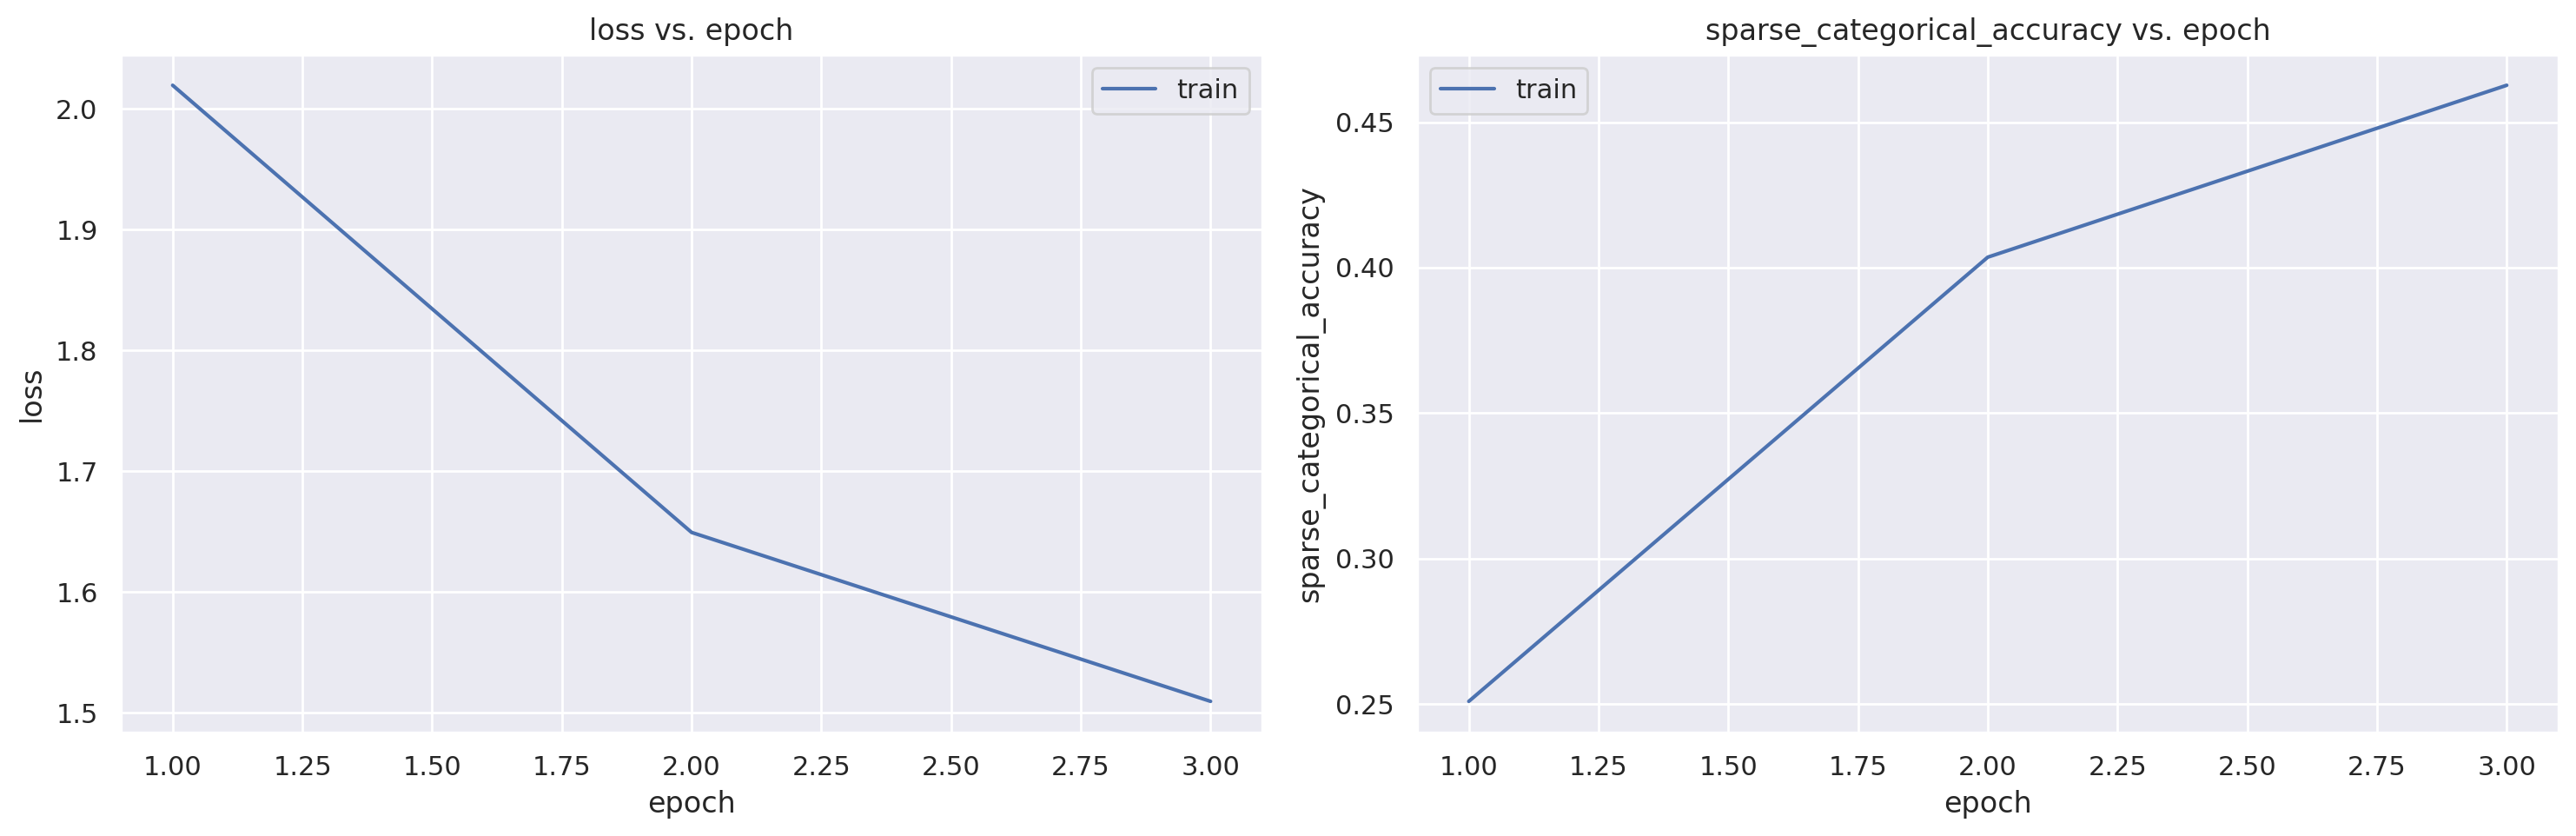

In [12]:
# Fit model, with simple checkpoint which saves (and overwrites) 
# model weights every epoch
history = model.fit(x=x_train, y=y_train, 
    epochs=3, callbacks=[checkpoint], verbose=0)

# Plot training history
PlotHistory(history, metrics=['loss', 'sparse_categorical_accuracy'])\
    .plot()

In [13]:
# Have a look at what the checkpoint creates
! ls -lh model_checkpoints

total 184K
-rw-r--r-- 1 meng users   77 Nov  3 15:19 checkpoint
-rw-r--r-- 1 meng users 174K Nov  3 15:19 checkpoint.data-00000-of-00001
-rw-r--r-- 1 meng users 2.0K Nov  3 15:19 checkpoint.index


In [14]:
# Evaluate the performance of the trained model
get_test_accuracy(model, x_test, y_test)

accuracy: 0.440


#### Create new model, load weights

In [15]:
# Create a new instance of the (initialised) model, 
# accuracy around 10% again
model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.094


In [16]:
# Load weights -- accuracy is the same as the trained model
model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.440


#### Clear directory

In [17]:
! rm -r model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), 
        tf.keras.metrics.MeanAbsoluteError()]
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'training_run_1/my_model.{epoch}-{val_loss:.4f}',
    save_weights_only=True, save_freq='epoch', verbose=2,
    save_best_only=True, mode='max', 
    monitor='val_sparse_categorical_accuracy'
)
model.fit(X_train, y_train, validation_data=(X_val, y_val),
    epochs=10, batch_size=16, callbacks=[checkpoint], verbose=0
)

#### Create more customised checkpoint

In [18]:
# Create Tensorflow checkpoint object with epoch and batch details
checkpoint_1000_path = \
    'model_checkpoints_1000/checkpoint_{epoch:02d}_{batch:04d}'
checkpoint_1000 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_1000_path,
    save_weights_only=True, save_freq=1000, verbose=2)


Epoch 1: saving model to model_checkpoints_1000/checkpoint_01_1000

Epoch 2: saving model to model_checkpoints_1000/checkpoint_02_1000

Epoch 3: saving model to model_checkpoints_1000/checkpoint_03_1000


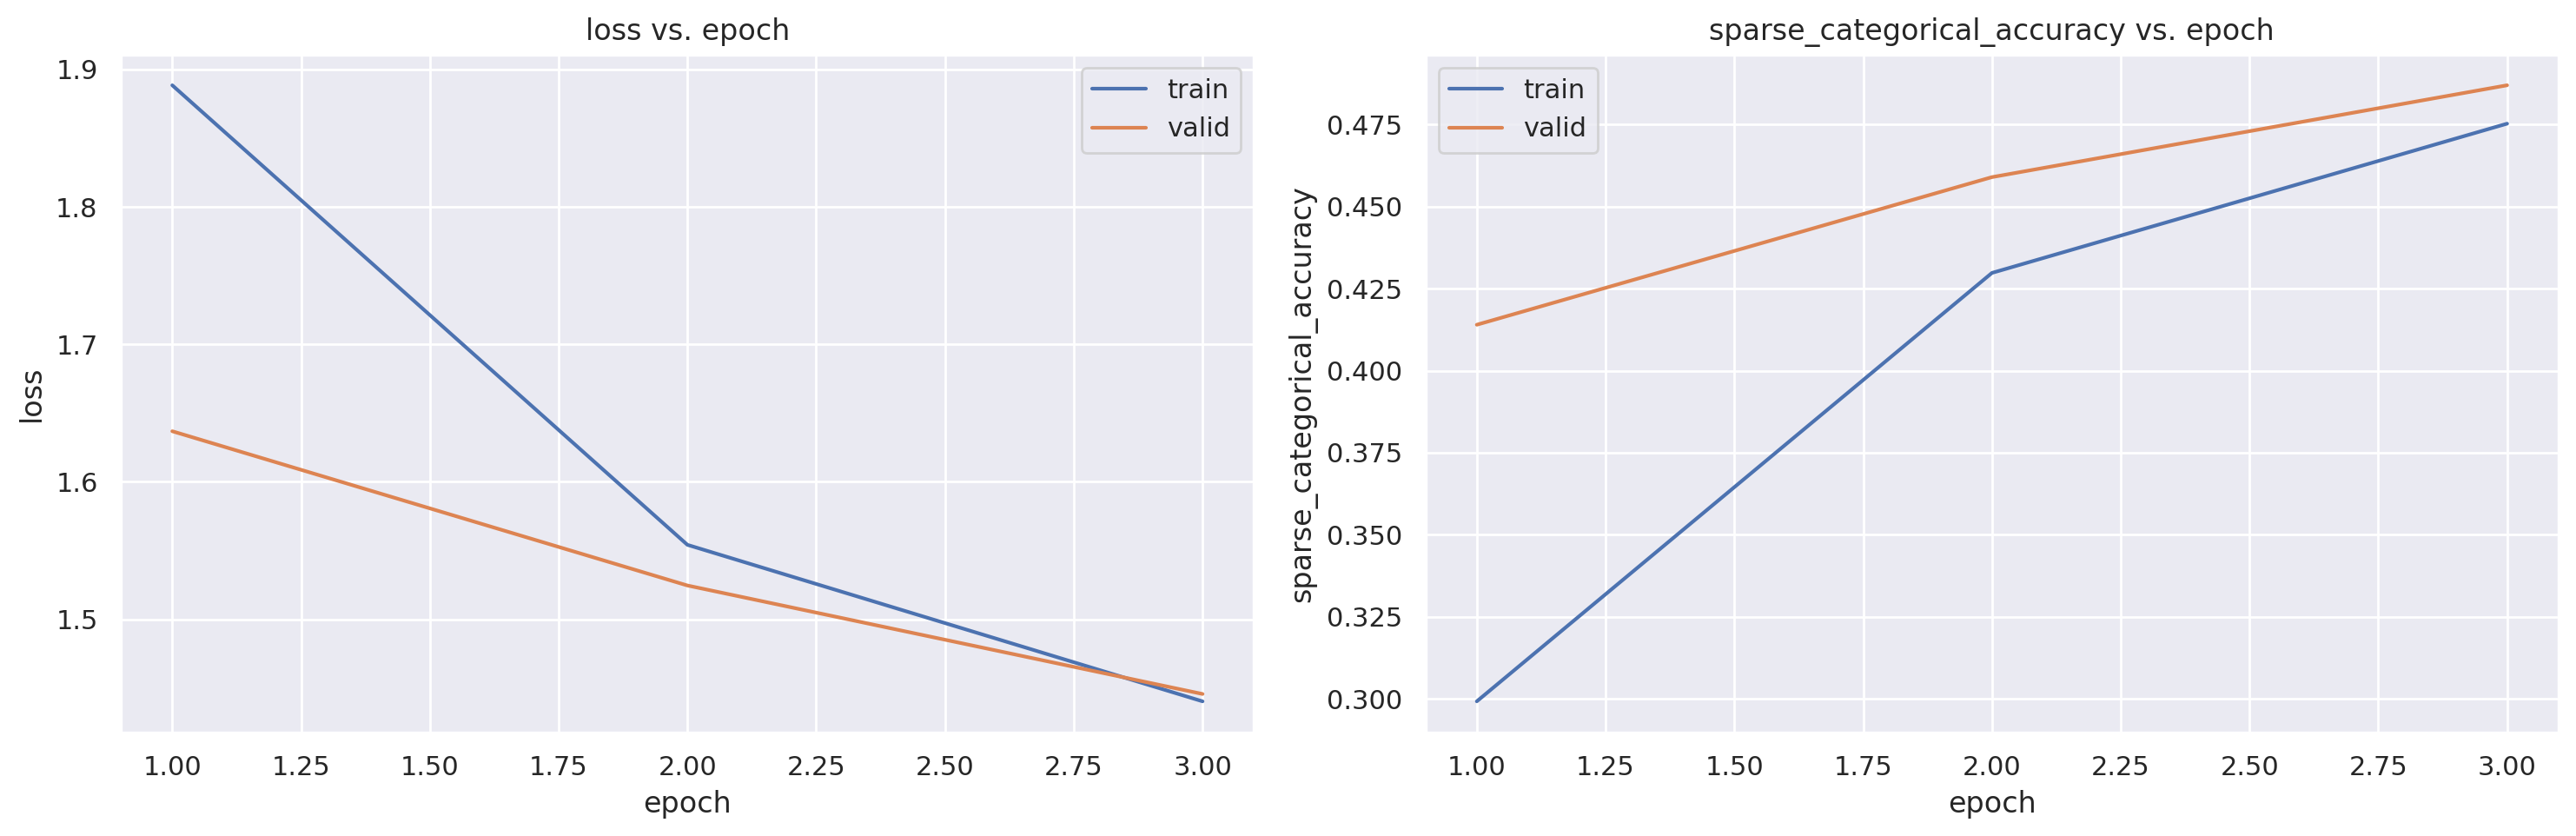

In [19]:
# Create and fit model with checkpoint
model = get_new_model()
history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), 
    epochs=3, batch_size=10, verbose=0, callbacks=[checkpoint_1000])

# Plot training history
PlotHistory(history, metrics=['loss', 'sparse_categorical_accuracy'])\
    .plot()

In [20]:
# Have a look at what the checkpoint creates
! ls -lh model_checkpoints_1000

total 544K
-rw-r--r-- 1 meng users   93 Nov  3 15:19 checkpoint
-rw-r--r-- 1 meng users 174K Nov  3 15:19 checkpoint_01_1000.data-00000-of-00001
-rw-r--r-- 1 meng users 2.0K Nov  3 15:19 checkpoint_01_1000.index
-rw-r--r-- 1 meng users 174K Nov  3 15:19 checkpoint_02_1000.data-00000-of-00001
-rw-r--r-- 1 meng users 2.0K Nov  3 15:19 checkpoint_02_1000.index
-rw-r--r-- 1 meng users 174K Nov  3 15:19 checkpoint_03_1000.data-00000-of-00001
-rw-r--r-- 1 meng users 2.0K Nov  3 15:19 checkpoint_03_1000.index


#### Work with model saving criteria

In [21]:
# Use tiny training and test set -- will overfit!
x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [22]:
# Create a new instance of untrained model
model = get_new_model()

In [23]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_best_path,
    save_weights_only=True, save_freq='epoch', save_best_only=True, verbose=2,
    monitor='val_sparse_categorical_accuracy')


Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.10000, saving model to model_checkpoints_best/checkpoint

Epoch 2: val_sparse_categorical_accuracy did not improve from 0.10000

Epoch 3: val_sparse_categorical_accuracy did not improve from 0.10000

Epoch 4: val_sparse_categorical_accuracy did not improve from 0.10000

Epoch 5: val_sparse_categorical_accuracy did not improve from 0.10000

Epoch 6: val_sparse_categorical_accuracy did not improve from 0.10000

Epoch 7: val_sparse_categorical_accuracy did not improve from 0.10000

Epoch 8: val_sparse_categorical_accuracy did not improve from 0.10000

Epoch 9: val_sparse_categorical_accuracy improved from 0.10000 to 0.11000, saving model to model_checkpoints_best/checkpoint

Epoch 10: val_sparse_categorical_accuracy improved from 0.11000 to 0.14000, saving model to model_checkpoints_best/checkpoint

Epoch 11: val_sparse_categorical_accuracy did not improve from 0.14000

Epoch 12: val_sparse_categorical_accuracy did not impr

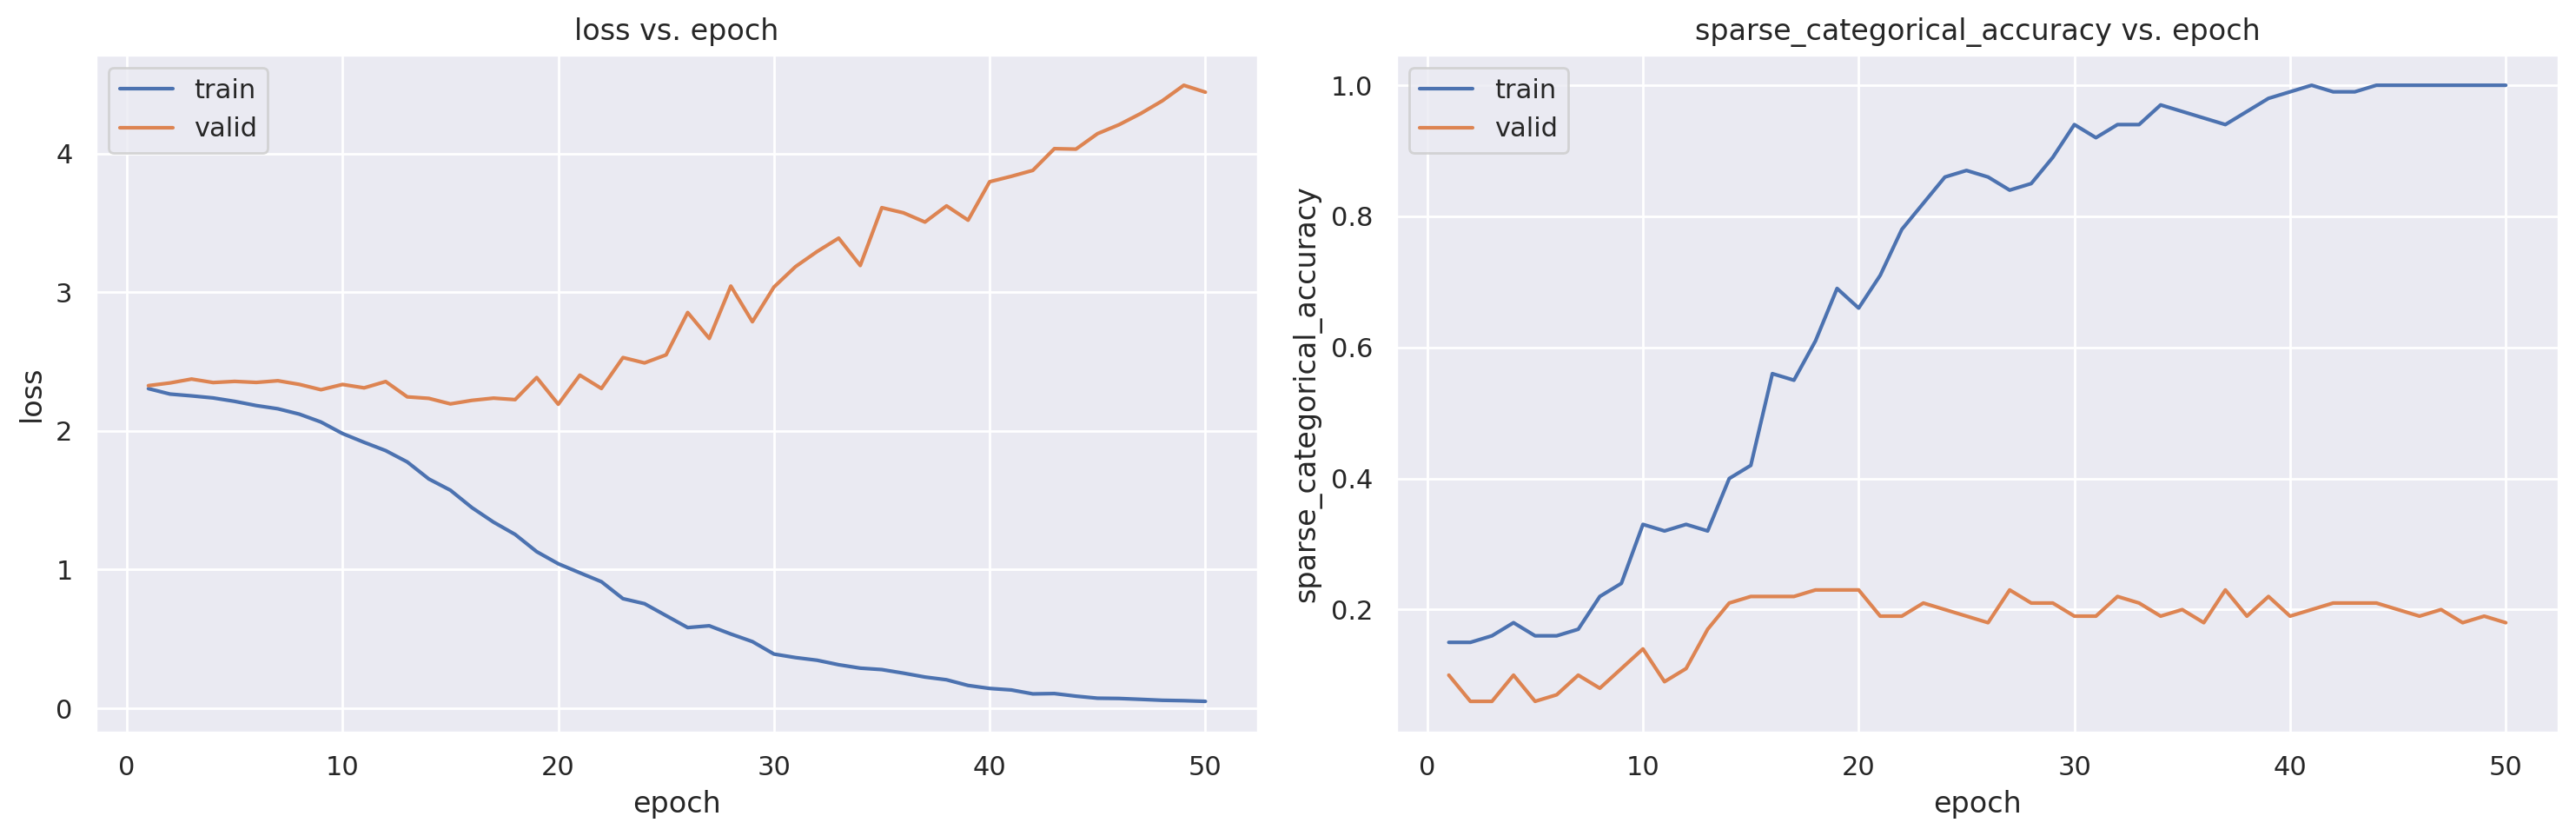

In [24]:
# Fit the model and save only the weights with the highest validation accuracy
history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), 
    epochs=50, batch_size=10, callbacks=[checkpoint_best], verbose=0)

# Plot training history
PlotHistory(history, metrics=['loss', 'sparse_categorical_accuracy'])\
    .plot()

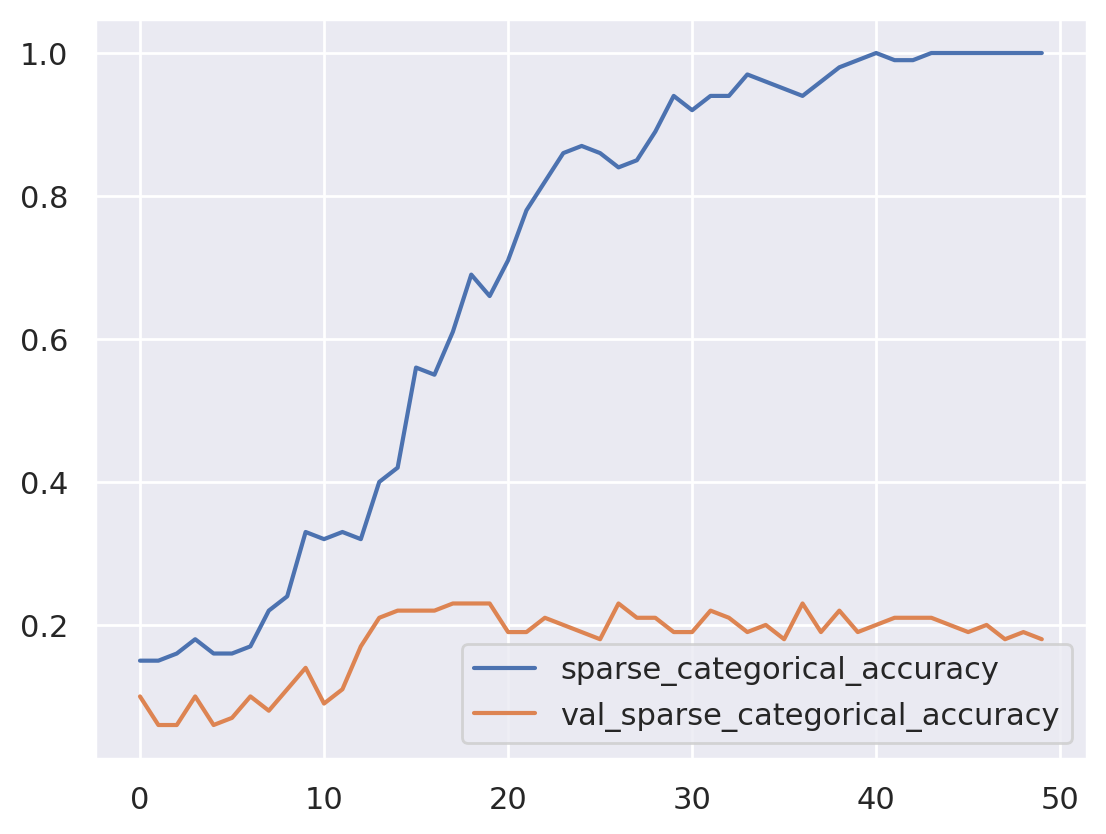

In [25]:
# Plot training and testing curves
df = pd.DataFrame(history.history)
df.plot(y=['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])
plt.show()

In [26]:
# Inspect the checkpoint directory
! ls -lh model_checkpoints_best

total 184K
-rw-r--r-- 1 meng users   77 Nov  3 15:20 checkpoint
-rw-r--r-- 1 meng users 174K Nov  3 15:20 checkpoint.data-00000-of-00001
-rw-r--r-- 1 meng users 2.0K Nov  3 15:20 checkpoint.index


In [27]:
# Create a new model with the saved weights
new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.230


#### Clear directory

In [28]:
! rm -r model_checkpoints_1000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), 
        tf.keras.metrics.MeanAbsoluteError()]
)
checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model', 
    save_weights_only=False
)
model.fit(X_train, y_train, 
    epochs=10, callbacks=[checkpoint], verbose=0
)

# my_model/assests/
# my_model/saved_model.pb
# my_model/variables/variables.data-00000-of-00001
# my_model/variables/variables.index

checkpoint = tf.keras.callbacks.ModelCheckpoint('keras_model.h5',
    save_weights_only=False
)
model.fit(X_train, y_train, 
    epochs=10, callbacks=[checkpoint], verbose=0
)

# keras_model.h5

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), 
        tf.keras.metrics.MeanAbsoluteError()]
)
model.fit(X_train, y_train, 
    epochs=10, verbose=0
)
model.save('my_model') # SavedModel format

model.save('keras_model.h5') # HDF5 format

In [ ]:
new_model = tf.keras.models.load_model('my_model')
new_keras_model = tf.keras.models.load_model('keras_model.h5')

new_model.summary()
new_model.fit(X_train, y_train, validation_data=(X_val, y_val),
    epochs=20, batch_size=16, verbose=0
)
new_model.evaluate(X_test, y_test, verbose=0)
new_model.predict(X_samples, verbose=0)

#### Create checkpoint that saves whole model, not just weights

In [29]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
    save_weights_only=False, frequency='epoch', verbose=2)


Epoch 1: saving model to model_checkpoints

Epoch 2: saving model to model_checkpoints

Epoch 3: saving model to model_checkpoints


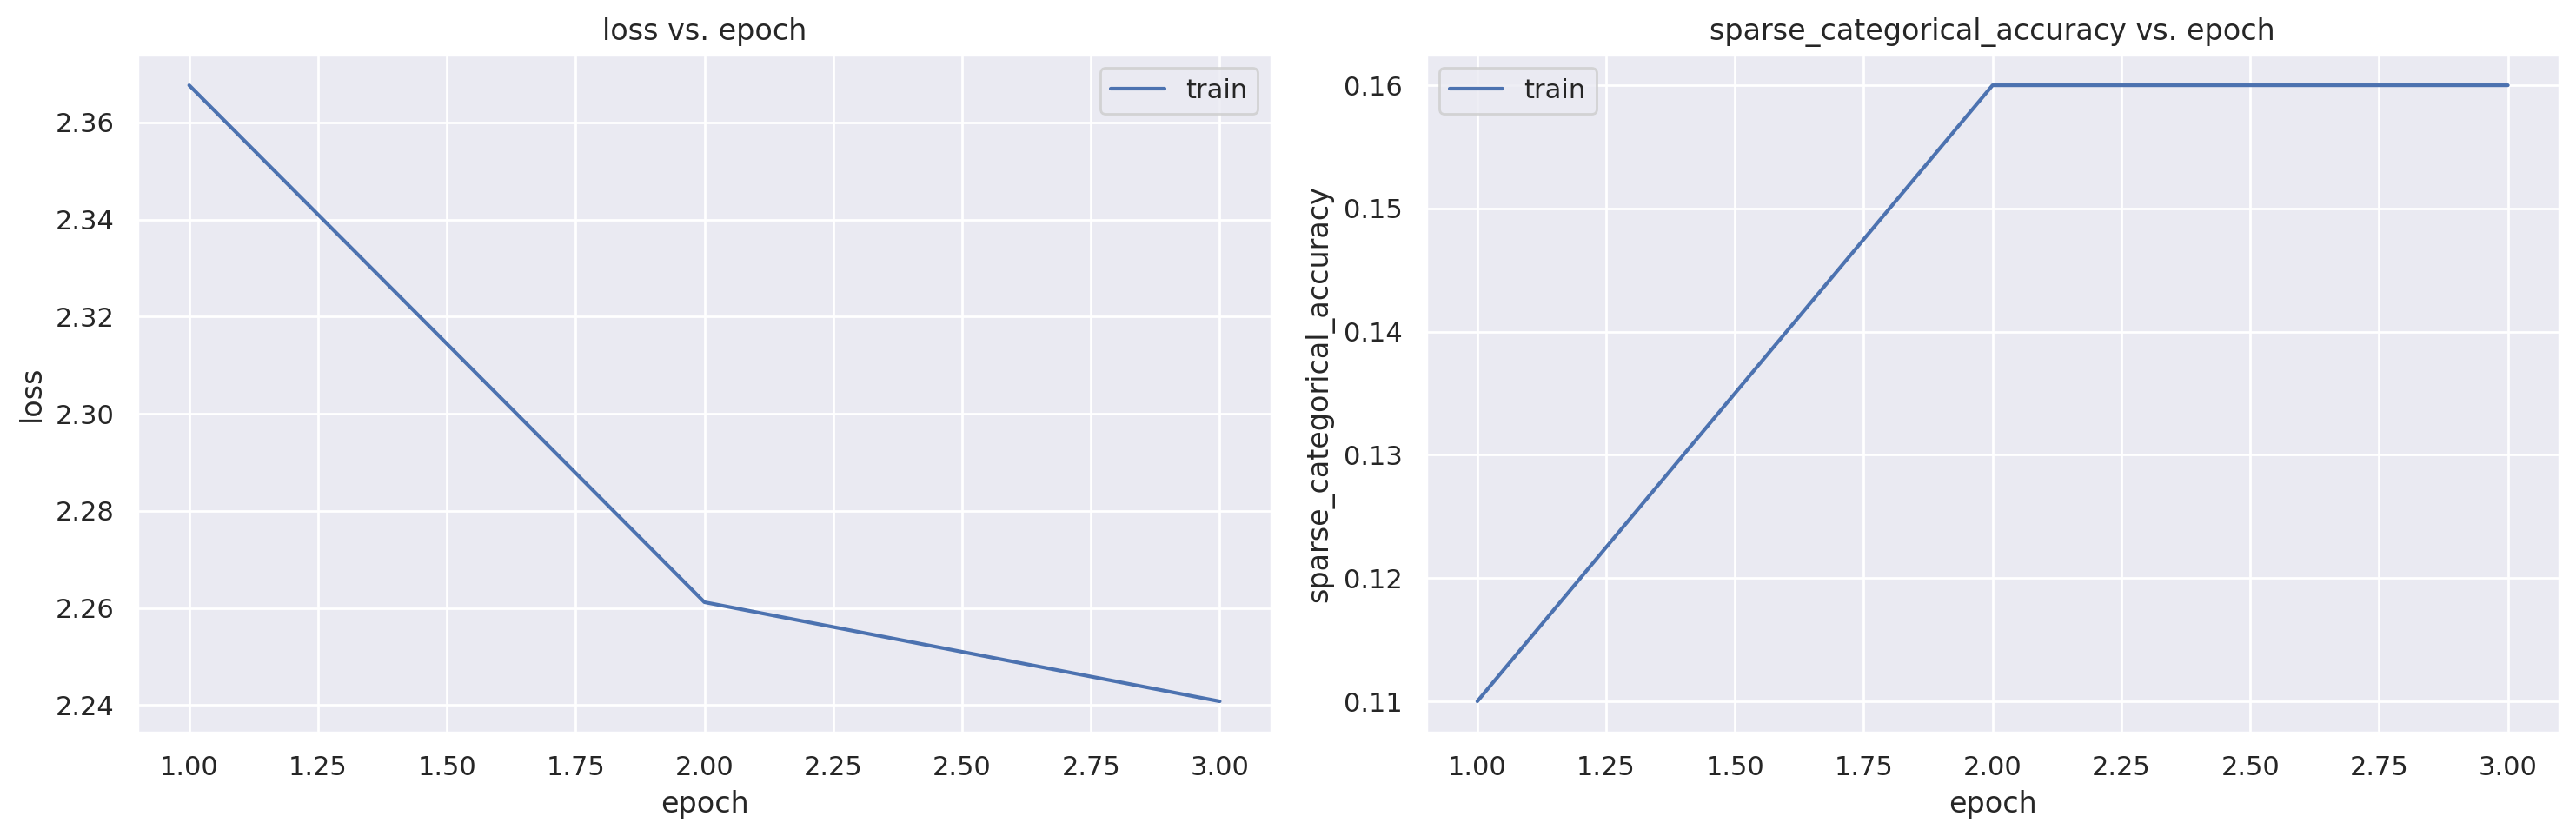

In [30]:
# Create and fit model with checkpoint
model = get_new_model()
history = model.fit(x=x_train, y=y_train, 
    epochs=3, callbacks=[checkpoint], verbose=0)

# Plot training history
PlotHistory(history, metrics=['loss', 'sparse_categorical_accuracy'])\
    .plot()

#### Inspect what the checkpoint has created

In [31]:
# Have a look at what the checkpoint creates
! ls -lh model_checkpoints

total 148K
drwxr-xr-x 2 meng users 4.0K Nov  3 15:20 assets
-rw-r--r-- 1 meng users  15K Nov  3 15:20 keras_metadata.pb
-rw-r--r-- 1 meng users 123K Nov  3 15:20 saved_model.pb
drwxr-xr-x 2 meng users 4.0K Nov  3 15:20 variables


In [32]:
# Enter variables directory
! ls -lh model_checkpoints/variables

total 184K
-rw-r--r-- 1 meng users 179K Nov  3 15:20 variables.data-00000-of-00001
-rw-r--r-- 1 meng users 2.2K Nov  3 15:20 variables.index


In [33]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)

accuracy: 0.060


#### Create new model from scratch

In [34]:
# Delete model
del model

In [35]:
# Reload model from scratch
model = tf.keras.models.load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.060


#### Use the .h5 format to save model

In [36]:
# Save the model in .h5 format
model.save('my_model.h5')

In [37]:
# Inspect .h5 file
! ls -lh my_model.h5

-rw-r--r-- 1 meng users 78K Nov  3 15:21 my_model.h5


In [38]:
# Delete model
del model

In [39]:
# Reload model from scratch
model = tf.keras.models.load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.060


#### Clear directory

In [40]:
! rm -r model_checkpoints
! rm my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

In [ ]:
model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet', include_top=True)

img_input = tf.keras.utils.load_img('data/lemon.jpg',
    target_size=(224, 224))
img_input = tf.keras.utils.img_to_array(img_input)
img_input = tf.keras.applications.resnet50.preprocess_input(
    img_input[np.newaxis, ...])

preds = model.predict(img_input, verbose=0)
# List of (class, description, probability)
decoded_predictions = tf.keras.applications.resnet50.decode_predictions(
    preds, top=3)[0]
print(decoded_predictions)

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model from disk.

In [41]:
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet')
model.save('./models/Keras_ResNet50.h5')
del model

102967424/102967424 [==============================] - 3s 0us/step


In [42]:
# Build Keras ResNet50 model

model = tf.keras.models.load_model('./models/Keras_ResNet50.h5')

#### Import and preprocess 3 sample images

In [43]:
# Import 3 sample ImageNet images
lemon_img = tf.keras.utils.load_img(
    './data/lemon.jpg', target_size=(224, 224))
viaduct_img = tf.keras.utils.load_img(
    './data/viaduct.jpg', target_size=(224, 224))
water_tower_img = tf.keras.utils.load_img(
    './data/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [44]:
# Useful function: presents top 5 predictions and probabilities
def get_top_5_predictions(img):
    x = tf.keras.utils.img_to_array(img)[np.newaxis, ...]
    x = tf.keras.applications.resnet50.preprocess_input(x)
    preds = tf.keras.applications.resnet50.decode_predictions(
        model.predict(x, verbose=0), top=5)
    top_preds = pd.DataFrame(
        columns=['prediction', 'probability'],
        index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

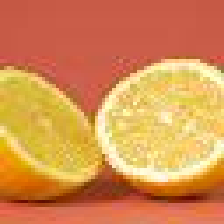

In [45]:
# Display image
lemon_img

In [46]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)

35363/35363 [==============================] - 0s 0us/step


,prediction,probability
1,consomme,0.237066
2,eggnog,0.226406
3,lemon,0.199256
4,face_powder,0.030634
5,ladle,0.030448


##### Image 2: viaduct

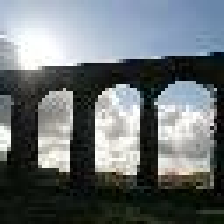

In [47]:
# Display image
viaduct_img

In [48]:
# Display top 5 predictions
get_top_5_predictions(viaduct_img)

,prediction,probability
1,vault,0.433361
2,viaduct,0.113641
3,prison,0.107957
4,window_screen,0.067979
5,megalith,0.016871


##### Image 3: water tower

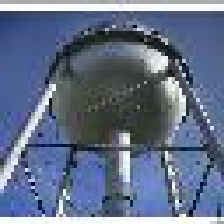

In [49]:
# Display image
water_tower_img

In [50]:
# Display top 5 predictions
get_top_5_predictions(water_tower_img)

,prediction,probability
1,solar_dish,0.483133
2,ladle,0.165878
3,planetarium,0.101512
4,strainer,0.052545
5,jigsaw_puzzle,0.023844


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Tensorflow SavedModel format. If you want to import it on your personal machine, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In this coding tutorial, you will instead load the model directly from disk.

In [51]:
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/5"
model = tf.keras.Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
model.save('./models/Tensorflow_MobileNet_v1')
del model

In [52]:
# Build Google's Mobilenet v1 model
module = tf.keras.models.load_model('./models/Tensorflow_MobileNet_v1')
model = tf.keras.Sequential([hub.KerasLayer(module)])
model.build(input_shape=(None, 160, 160, 3))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              1343049   
                                                                 
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [53]:
# Import and preprocess 3 sample ImageNet images
lemon_img = tf.keras.utils.load_img("./data/lemon.jpg", 
    target_size=(160, 160))
viaduct_img = tf.keras.utils.load_img("./data/viaduct.jpg", 
    target_size=(160, 160))
water_tower_img = tf.keras.utils.load_img("./data/water_tower.jpg", 
    target_size=(160, 160))

In [54]:
# Read in categories text file

with open('./data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [55]:
# Useful function: presents top 5 predictions
def get_top_5_predictions(img):
    x = tf.keras.utils.img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x, verbose=0)
    top_preds = pd.DataFrame(columns=['prediction'], 
        index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
    return top_preds

##### Image 1: lemon

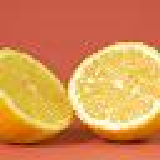

In [56]:
lemon_img

In [57]:
get_top_5_predictions(lemon_img)

,prediction
1,shower cap
2,tray
3,Petri dish
4,candle
5,brassiere


##### Image 2: viaduct

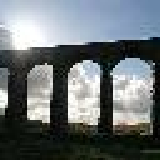

In [58]:
viaduct_img

In [59]:
get_top_5_predictions(viaduct_img)

,prediction
1,viaduct
2,dam
3,pier
4,monastery
5,prison


##### Image 3: water tower

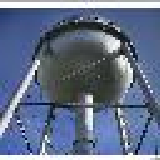

In [60]:
water_tower_img

In [61]:
get_top_5_predictions(water_tower_img)

,prediction
1,solar dish
2,water tower
3,jigsaw puzzle
4,castle
5,aircraft carrier
